## Finding RGB channel normalisation params

In [153]:
# Get pixel data
# Random sample
# Extract and print channel means and std_dev

# We always normalise as final image augmentation, since if you're using saturation 
# or any sort of colour augmentation normalisation gets fucked

In [47]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from PIL import Image
from skimage.transform import resize
import os

CHANNELS = ['red', 'green', 'blue', 'yellow']
TRAIN_CSV = 'D:/HPA_comp/single_cells/train.csv'
IMG_DIR = 'D:/HPA_comp/single_cells'

class CellDataset(object):
    '''Dataset class to fetch HPA cell-level images
    and corresponding weak labels
    '''
    def __init__(self, images, targets, img_root, augmentations=None):
        self.images = images
        self.targets = targets
        self.img_root = img_root
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_id = self.images[idx] 
        img_channels = self._fetch_channels(img_id)
        img = self._channels_2_array(img_channels)
        img = resize(img, (224, 224))  # Always resize cell images for collate function
        # If augmentation pipeline provided, apply augmentations
        if self.augmentations:
            img = self.augmentations(image=img)['image']
        # Adjust to channel first indexing for pytorch (speed reasons)
        features = np.transpose(img, (2, 0, 1)).astype(np.float32)
        target = self.targets[idx]  # Grab target vector
        
        return {'image': torch.tensor(features),
                'target': torch.tensor(target)
                }
    
    def _fetch_channels(self, img_id: str, channel_names=CHANNELS):
        'Return absolute path of segmentation channels of a given image id'
        base = os.path.join(self.img_root, img_id)
        return [base + '_' + i  + '.png' for i in channel_names]
                                         
    def _channels_2_array(self, img_channels):
        'Return 3D array of pixel values of input image channels'
        # Init and reshape single channel array so we can concat other channels
        channel_1 = np.array(Image.open(img_channels[0]))
        shape = channel_1.shape + (1,)  
        pixel_arr = channel_1.reshape(shape)
        # Lay out 4 channels in 3D array for model input
        for channel in img_channels[1:3]:
            channel_values = np.array(Image.open(channel)).reshape(shape)
            pixel_arr = np.concatenate([pixel_arr, channel_values], axis=2)
        return pixel_arr

In [4]:
def gen_dataloader(df, img_dir, bs, shuffle, aug=None):
        'Return pytorch dataloader generated from cell image dataframe'
        # Extract images and targets as numpy arrays from dataframe tranche
        def extract_as_array(str_):
            list_ = str_.strip('][').split(', ')
            return np.array([int(i) for i in list_])
        images = df['cell_id'].values
        targets = df['Label'].apply(extract_as_array).values
        # Init custom dataset class and pass to pytorch
        dataset = CellDataset(images, targets, img_dir, aug)
        return DataLoader(dataset, batch_size=bs, shuffle=shuffle)

In [13]:
def grab_pixel_aggs(dataloader, sample_size):
    'Return dataframe of image channel means and standard deviations'
    aggs_df = pd.DataFrame()
    
    for count, sample in enumerate(dataloader):
        image_tensor = sample['image']  # indexed by (C, H, W)
        aggs = {}
        # Grab cell image channel aggregates
        channels = ['red', 'green', 'blue']
        for idx, channel_name in enumerate(channels):
            channel = image_tensor[0, idx, :, :]
            min_value = channel.min().item()
            max_value = channel.max().item()
            mean = channel.mean().item()
            std = channel.std().item()
            aggs[channel_name + '_max'] = max_value
            aggs[channel_name + '_min'] = min_value
            aggs[channel_name + '_mean'] = mean
            aggs[channel_name + '_std'] = std
        aggs_df = aggs_df.append(aggs, ignore_index=True)
        if count >= sample_size:
            break
    return aggs_df

In [48]:
df = pd.read_csv(TRAIN_CSV, index_col=0)
loader = gen_dataloader(df, img_dir=IMG_DIR, bs=1, shuffle=True, aug=None)
aggs_df = grab_pixel_aggs(loader, sample_size=1000)
aggs_df.head()

,blue_max,blue_mean,blue_min,blue_std,green_max,green_mean,green_min,green_std,red_max,red_mean,red_min,red_std
0,1.017685e-07,3.407981e-09,2.328306e-10,1.366696e-08,9.773566e-08,3.075792e-09,2.328306e-10,6.779227e-09,1.180451e-07,1.170326e-08,2.328306e-10,1.965228e-08
1,5.177885e-08,3.485120e-09,2.328306e-10,8.719230e-09,4.949080e-08,8.663201e-10,2.328306e-10,1.782882e-09,8.466778e-08,3.266735e-09,2.328306e-10,6.834032e-09
2,9.433873e-09,1.190104e-09,2.328306e-10,1.307362e-09,2.844981e-08,2.374449e-09,2.328306e-10,3.033945e-09,4.196163e-08,4.602498e-09,2.328306e-10,5.035229e-09
3,1.174547e-07,1.950569e-08,2.328306e-10,2.694077e-08,1.188808e-07,1.770982e-08,2.328306e-10,1.975254e-08,1.112879e-07,8.423744e-09,2.328306e-10,1.386540e-08
4,1.171887e-07,5.739611e-09,2.328306e-10,1.876061e-08,1.175805e-07,2.035665e-08,2.328306e-10,2.426175e-08,1.097973e-07,1.481661e-08,2.328306e-10,1.816342e-08
5,4.459000e-08,3.574714e-09,2.328306e-10,7.023750e-09,1.154131e-07,1.183415e-08,2.328306e-10,1.235096e-08,1.028830e-07,9.569090e-09,2.328306e-10,1.264736e-08
6,7.369000e-08,1.299507e-08,2.328306e-10,1.657644e-08,1.189765e-07,1.533726e-08,2.328306e-10,1.646218e-08,1.168788e-07,1.974368e-08,2.328306e-10,2.007542e-08
7,1.180264e-07,8.287586e-09,2.328306e-10,2.125565e-08,1.185108e-07,1.016177e-08,2.328306e-10,2.078091e-08,1.180309e-07,9.790337e-09,2.328306e-10,1.650134e-08
8,9.368039e-08,4.320826e-09,2.328306e-10,1.467616e-08,1.131844e-07,1.448359e-09,2.328306e-10,5.573459e-09,1.189765e-07,1.082976e-08,2.328306e-10,1.585119e-08
9,1.101278e-07,7.547926e-09,2.328306e-10,1.769076e-08,8.495734e-08,3.065560e-09,2.328306e-10,4.675860e-09,1.159016e-07,9.108168e-09,2.328306e-10,1.460226e-08


In [98]:
# Re-scale magic numbers
PIL_min = 2.3283e-10
PIL_max = 1.189765e-07
new_min = 0
new_max = 255
PIL_range = (PIL_max - PIL_min)  
new_range = (new_max - new_min)

rescale = lambda value: int((((value - PIL_min) * new_range) / PIL_range) + new_min)

### Grab example image

In [120]:
for i in loader:
    img = i['image']
    break

(224, 224, 3)


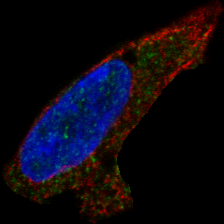

In [152]:
array_img = np.array(img)[0, :, :, :]
array_img = np.transpose(array_img, (1, 2, 0))

from PIL import Image
Image.fromarray(array_img.astype('uint8'))

### Convert back to integer pixel values

In [121]:
img[0, :, :, :].apply_(rescale)

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ..., 11.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])

### Check scale

In [122]:
# Total non-integer values (account for rounding error)
((img % 1) >= 1e-6).sum().item()

0

In [123]:
# Rescaled pixel range
print(img.min().item())
print(img.max().item())

0.0
242.0


### Check normalized and rescaled images look the same

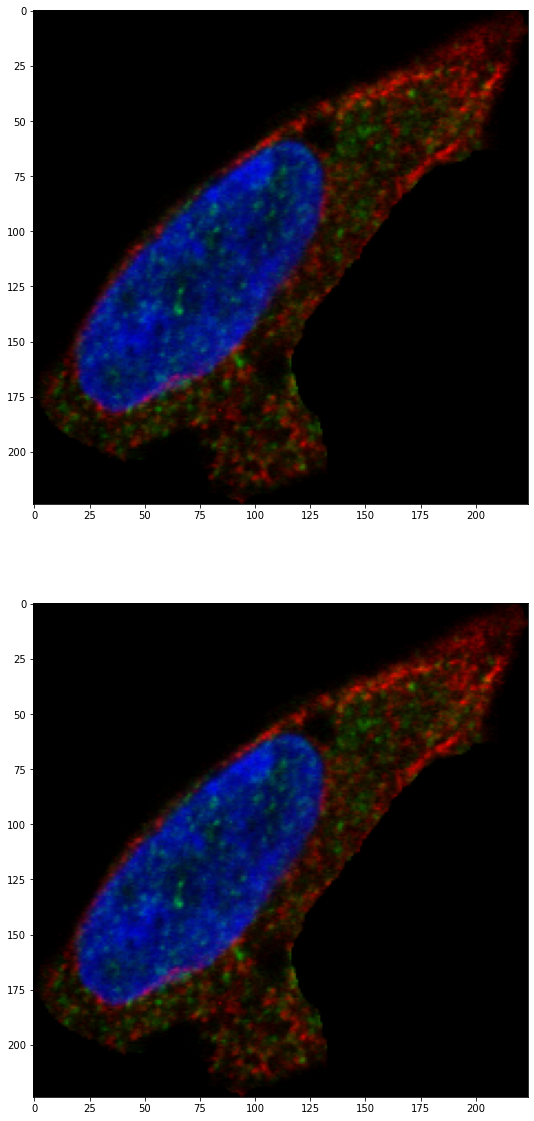

In [134]:
new = np.transpose(np.array(img[0, :, : ,:]), (1, 2, 0)).astype('uint8')
_, ax = plt.subplots(2, figsize=(20, 20))
ax[0].imshow(new)
normalised_new = new / 255
ax[1].imshow(new)